In [2]:
import mxnet as mx
import gluonnlp as nlp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

In [3]:
w2v = nlp.embedding.Word2Vec()

Embedding file GoogleNews-vectors-negative300-be6d6f98.npz is not found. Downloading from Gluon Repository. This may take some time.


In [4]:
nlp.embedding.list_sources('Word2Vec')

['GoogleNews-vectors-negative300',
 'freebase-vectors-skipgram1000-en',
 'freebase-vectors-skipgram1000']

In [5]:
len(w2v["man"])

300

In [6]:
# Download and uncompress this public domain dataset from:
# https://www.kaggle.com/datasets/therohk/million-headlines
headlines_full = pd.read_csv('abcnews-date-text.csv',parse_dates=[0], infer_datetime_format=True)

/tmp/ipykernel_1782/201405614.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  headlines_full = pd.read_csv('abcnews-date-text.csv',parse_dates=[0], infer_datetime_format=True)


In [7]:
headlines_full.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


In [8]:
number_headlines = len(headlines_full)
print(number_headlines)

1244184


In [9]:
reduced_number_headlines = int(0.05 * number_headlines)
print(reduced_number_headlines)

62209


In [10]:
# loc includes the last index, so to keep everything in order, we remove that last index
headlines = headlines_full.loc[:reduced_number_headlines - 1].copy()

In [11]:
import re
import string

# Cleaning the corpus
def clean_text(text):
    """
    Makes text lowercase for better comparison.
    Removes punctuation, trailing characters, text between
    square brackets, words containing numbers and links.
    Similar function to the one built for Chapter 2, Recipe 4
    """
    text = str(text).lower()
    text = re.sub("\[.*?\']", '', text)
    text = re.sub("https?://\S+|www\.\S+", '', text)
    text = re.sub("<.*?>+", '', text)
    text = re.sub("[%s]" % re.escape(string.punctuation), '', text)
    text = re.sub("\n", ' ', text)
    text = re.sub("\w*\d\w*", '', text)
    # No emails, so word subject can be interesting and is not removed
    # text = re.sub("subject", '', text)
    text = re.sub("\\r", ' ', text)
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    for p in punct:
        text = text.replace(p, '')
    return text

headlines["headline_text_clean"] = headlines["headline_text"].apply(clean_text)

# This deletes short words (2 characters or less)
headlines['headline_text_clean'] = headlines['headline_text_clean'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

headlines.head()

,publish_date,headline_text,headline_text_clean
0,2003-02-19,aba decides against community broadcasting lic...,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation,act fire witnesses must aware defamation
2,2003-02-19,a g calls for infrastructure protection summit,calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise,air staff aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers,air strike affect australian travellers


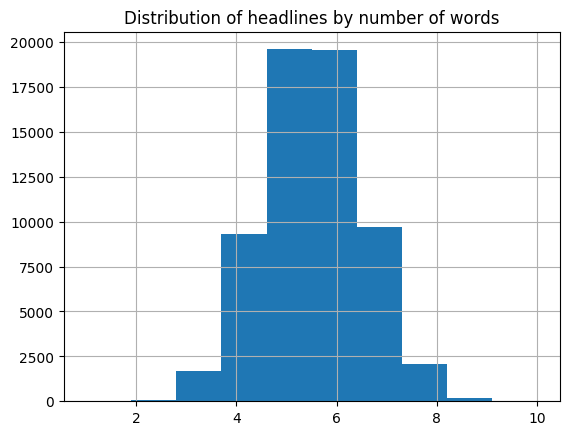

In [12]:
headlines['NumWords'] = headlines['headline_text_clean'].apply(lambda x: len(x.split()))
headlines[['NumWords']].hist()
plt.title("Distribution of headlines by number of words");

In [13]:
# Apply stop-words, stemming, lemmatization to all words

import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')

stemmer = nltk.stem.snowball.EnglishStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /home/sa_109024352321806746181/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sa_109024352321806746181/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sa_109024352321806746181/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/sa_109024352321806746181/nltk_data...


In [14]:
# Stop Words
stop_words = set(nltk.corpus.stopwords.words("english"))

In [15]:
def process_words(
    text,
    stop_words=stop_words,
    stemmer = stemmer,
    lemmatizer = lemmatizer):
    
    words = nltk.tokenize.word_tokenize(text)
       
    filtered_words_pre = []
    
    for word in words:
        
        if word not in stop_words and word.isalpha():
            word = stemmer.stem(word)
            filtered_words_pre.append(lemmatizer.lemmatize(word))
            
    filtered_words_pre = " ".join(filtered_words_pre) 
    
    return filtered_words_pre

In [16]:
headlines["headline_text_pre"] = headlines["headline_text_clean"].apply(process_words)

In [17]:
headlines.head()

,publish_date,headline_text,headline_text_clean,NumWords,headline_text_pre
0,2003-02-19,aba decides against community broadcasting lic...,aba decides against community broadcasting lic...,6,aba decid communiti broadcast licenc
1,2003-02-19,act fire witnesses must be aware of defamation,act fire witnesses must aware defamation,6,act fire wit must awar defam
2,2003-02-19,a g calls for infrastructure protection summit,calls for infrastructure protection summit,5,call infrastructur protect summit
3,2003-02-19,air nz staff in aust strike for pay rise,air staff aust strike for pay rise,7,air staff aust strike pay rise
4,2003-02-19,air nz strike to affect australian travellers,air strike affect australian travellers,5,air strike affect australian travel


In [18]:
# Pre-processing
# MXNet pre-trained model works with 300 embedding features
embedding_features = 300

# This is a very time-consuming process
average_embeddings_headlines_pre = mx.nd.empty((reduced_number_headlines, embedding_features))

for index, bag_of_words in tqdm(enumerate(headlines["headline_text_pre"]), total=reduced_number_headlines):
    bag_of_words_list = bag_of_words.split()
    number_of_words = len(bag_of_words_list)
    
    # Process 1st word (to be able to concatenate)
    word_embeddings_array = w2v[bag_of_words_list[0]].reshape(1, embedding_features)

    # To manage headlines with just 1 meaningful word
    word_index = -1
    for word_index, word in enumerate(bag_of_words_list[1:]):
        word_embeddings = w2v[word].reshape(1, embedding_features)
        word_embeddings_array = mx.nd.concat(word_embeddings_array, word_embeddings, dim=0)
    
    assert(number_of_words == word_index + 2)

    average_embedding_headline_pre = mx.nd.mean(word_embeddings_array, axis=0)
    average_embeddings_headlines_pre[index] = average_embedding_headline_pre

  0%|          | 0/62209 [00:00<?, ?it/s]

In [19]:
len(average_embeddings_headlines_pre)

62209

In [20]:
average_embeddings_headlines_pre[0].shape

(300,)

In [21]:
from sklearn.cluster import KMeans

cluster_km = KMeans(
    n_clusters=4,
    init='random',
    n_init=10,
    max_iter=300, 
    tol=1e-04,
    random_state=0
)

cluster_km_values = cluster_km.fit_predict(average_embeddings_headlines_pre.asnumpy())

In [31]:
headlines["topic_cluster"] = cluster_km_values

In [32]:
headlines.head()

,publish_date,headline_text,headline_text_clean,NumWords,headline_text_pre,topic_cluster
0,2003-02-19,aba decides against community broadcasting lic...,aba decides against community broadcasting lic...,6,aba decid communiti broadcast licenc,2
1,2003-02-19,act fire witnesses must be aware of defamation,act fire witnesses must aware defamation,6,act fire wit must awar defam,0
2,2003-02-19,a g calls for infrastructure protection summit,calls for infrastructure protection summit,5,call infrastructur protect summit,0
3,2003-02-19,air nz staff in aust strike for pay rise,air staff aust strike for pay rise,7,air staff aust strike pay rise,0
4,2003-02-19,air nz strike to affect australian travellers,air strike affect australian travellers,5,air strike affect australian travel,0


In [33]:
# Compute indexes per cluster
indexes_cluster_pre = []
indexes_cluster_pre.append(headlines["topic_cluster"] == 0)
indexes_cluster_pre.append(headlines["topic_cluster"] == 1)
indexes_cluster_pre.append(headlines["topic_cluster"] == 2)
indexes_cluster_pre.append(headlines["topic_cluster"] == 3)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [36]:
# Top-15 words per cluster
cluster_words = []
cluster_words.append(get_top_n_words(headlines[indexes_cluster_pre[0]]["headline_text_pre"], 15))
cluster_words.append(get_top_n_words(headlines[indexes_cluster_pre[1]]["headline_text_pre"], 15))
cluster_words.append(get_top_n_words(headlines[indexes_cluster_pre[2]]["headline_text_pre"], 15))
cluster_words.append(get_top_n_words(headlines[indexes_cluster_pre[3]]["headline_text_pre"], 15))

In [37]:
# Examples Cluster 0
headlines[indexes_cluster_pre[0]].head()

,publish_date,headline_text,headline_text_clean,NumWords,headline_text_pre,topic_cluster
1,2003-02-19,act fire witnesses must be aware of defamation,act fire witnesses must aware defamation,6,act fire wit must awar defam,0
2,2003-02-19,a g calls for infrastructure protection summit,calls for infrastructure protection summit,5,call infrastructur protect summit,0
3,2003-02-19,air nz staff in aust strike for pay rise,air staff aust strike for pay rise,7,air staff aust strike pay rise,0
4,2003-02-19,air nz strike to affect australian travellers,air strike affect australian travellers,5,air strike affect australian travel,0
12,2003-02-19,bathhouse plans move ahead,bathhouse plans move ahead,4,bathhous plan move ahead,0


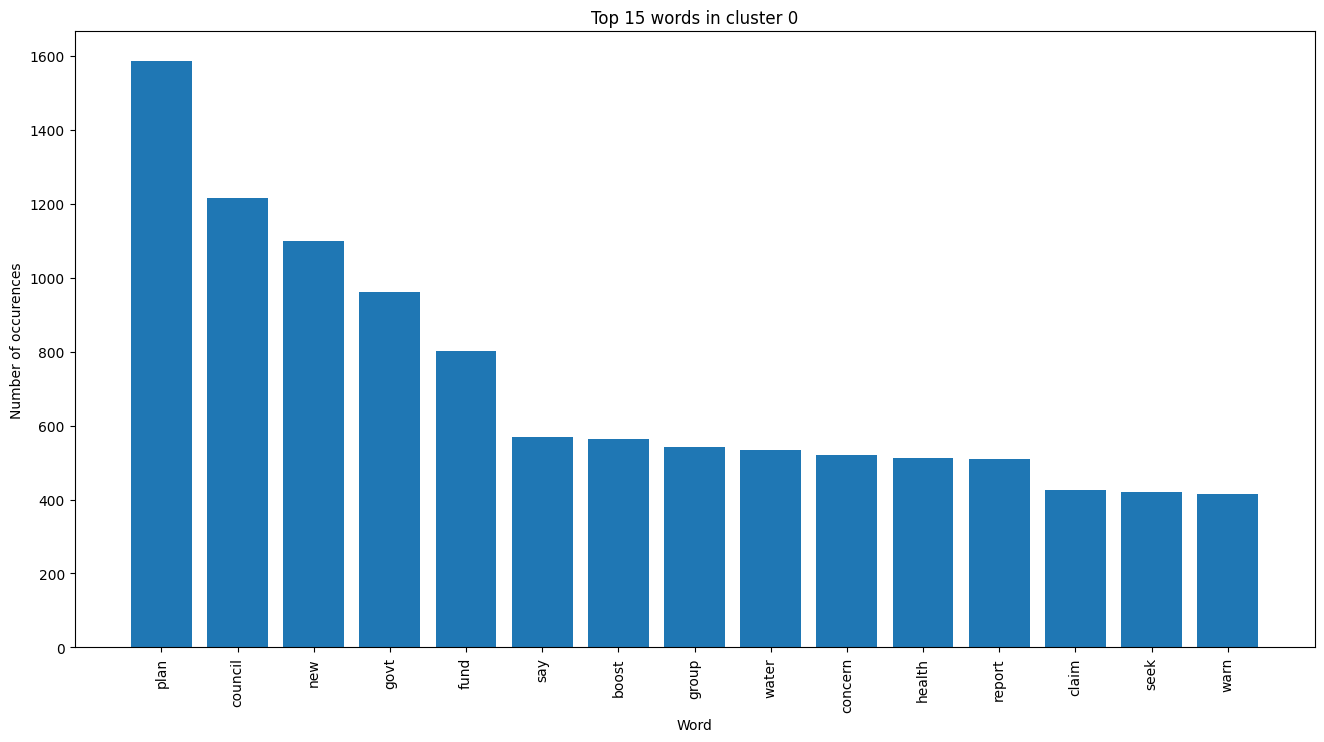

In [38]:
words = []
word_values = []

for i, j in cluster_words[0]:
    words.append(i)
    word_values.append(j)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 15 words in cluster 0');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [39]:
# Examples Cluster 1
headlines[indexes_cluster_pre[1]].head()

,publish_date,headline_text,headline_text_clean,NumWords,headline_text_pre,topic_cluster
5,2003-02-19,ambitious olsson wins triple jump,ambitious olsson wins triple jump,5,ambiti olsson win tripl jump,1
6,2003-02-19,antic delighted with record breaking barca,antic delighted with record breaking barca,6,antic delight record break barca,1
13,2003-02-19,big hopes for launceston cycling championship,big hopes for launceston cycling championship,6,big hope launceston cycl championship,1
18,2003-02-19,bryant leads lakers to double overtime win,bryant leads lakers double overtime win,6,bryant lead laker doubl overtim win,1
21,2003-02-19,calleri avenges final defeat to eliminate massu,calleri avenges final defeat eliminate massu,6,calleri aveng final defeat elimin massu,1


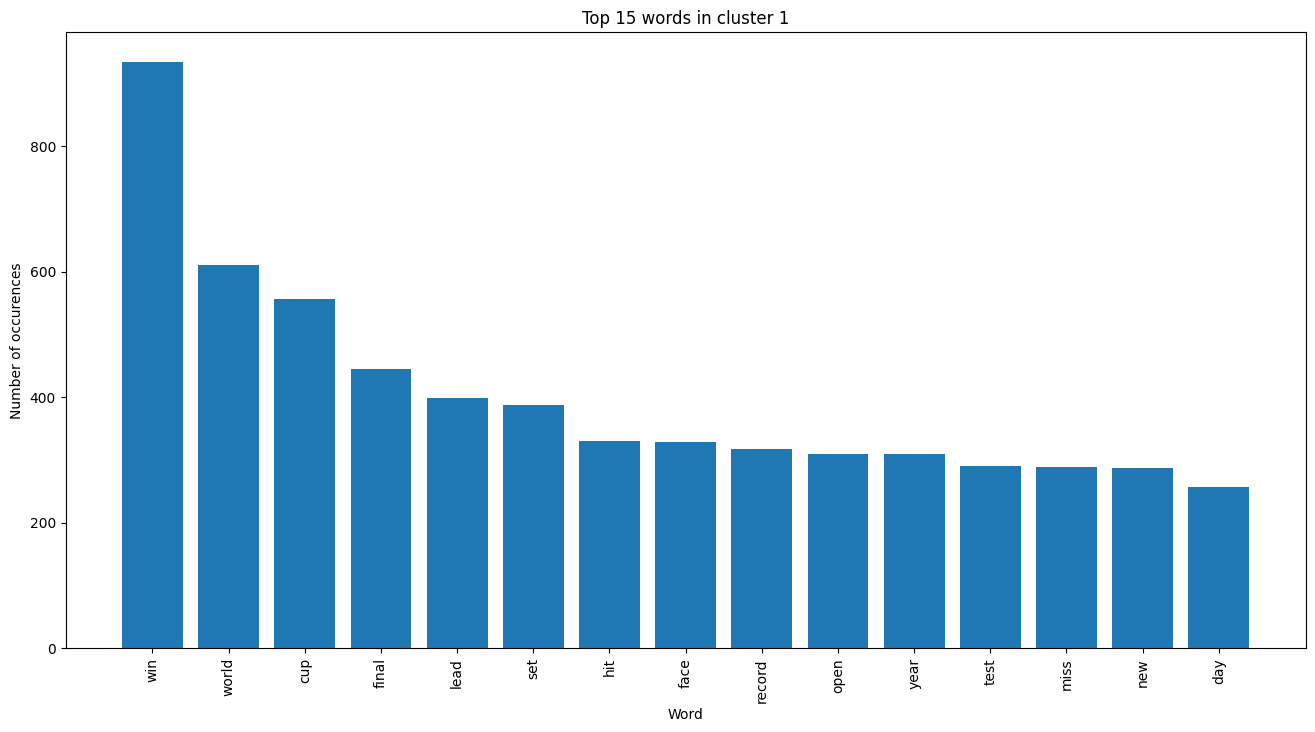

In [40]:
words = []
word_values = []

for i, j in cluster_words[1]:
    words.append(i)
    word_values.append(j)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 15 words in cluster 1');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [41]:
# Examples Cluster 2
headlines[indexes_cluster_pre[2]].head()

,publish_date,headline_text,headline_text_clean,NumWords,headline_text_pre,topic_cluster
0,2003-02-19,aba decides against community broadcasting lic...,aba decides against community broadcasting lic...,6,aba decid communiti broadcast licenc,2
7,2003-02-19,aussie qualifier stosur wastes four memphis match,aussie qualifier stosur wastes four memphis match,7,aussi qualifi stosur wast four memphi match,2
8,2003-02-19,aust addresses un security council over iraq,aust addresses security council over iraq,6,aust address secur council iraq,2
9,2003-02-19,australia is locked into war timetable opp,australia locked into war timetable opp,6,australia lock war timet opp,2
10,2003-02-19,australia to contribute 10 million in aid to iraq,australia contribute million aid iraq,5,australia contribut million aid iraq,2


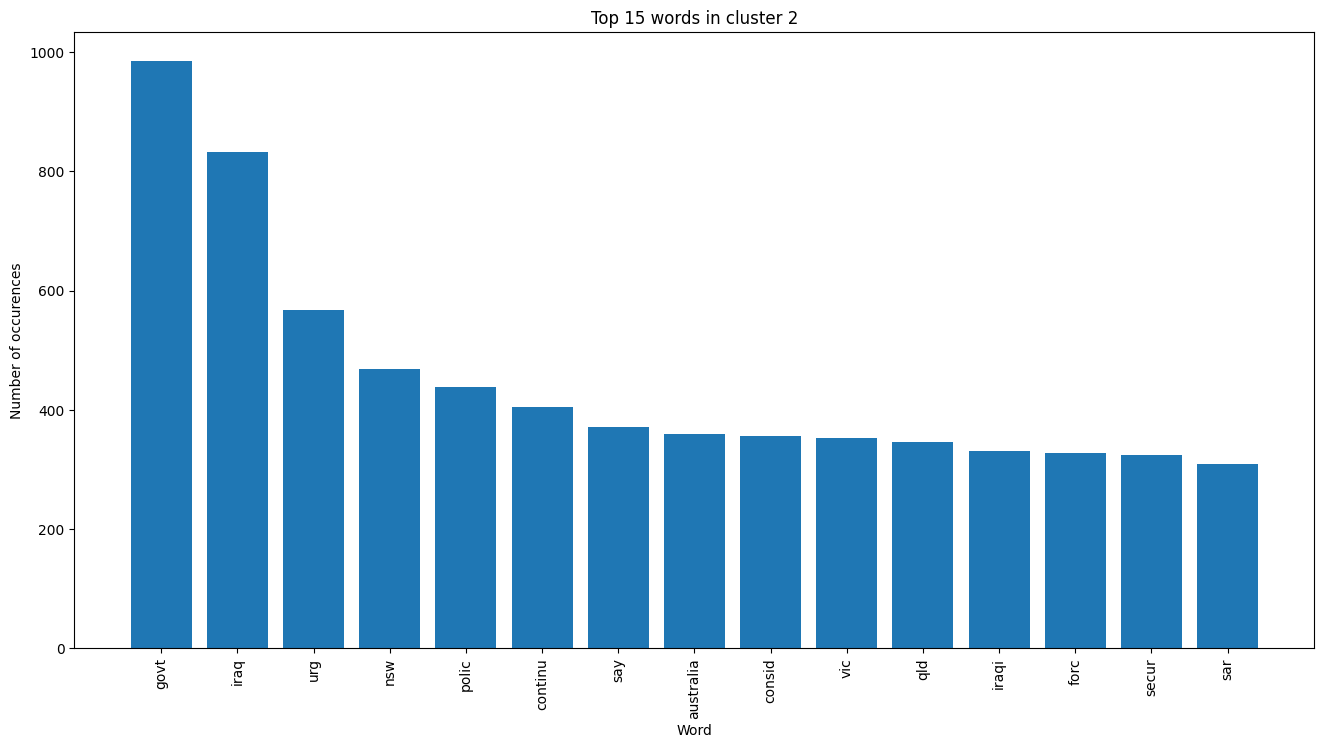

In [42]:
words = []
word_values = []

for i, j in cluster_words[2]:
    words.append(i)
    word_values.append(j)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 15 words in cluster 2');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [43]:
# Examples Cluster 3
headlines[indexes_cluster_pre[3]].head()

,publish_date,headline_text,headline_text_clean,NumWords,headline_text_pre,topic_cluster
19,2003-02-19,bushfire victims urged to see centrelink,bushfire victims urged see centrelink,5,bushfir victim urg see centrelink,3
42,2003-02-19,dog mauls 18 month old toddler in nsw,dog mauls month old toddler nsw,6,dog maul month old toddler nsw,3
48,2003-02-19,firefighters contain acid spill,firefighters contain acid spill,4,firefight contain acid spill,3
49,2003-02-19,four injured in head on highway crash,four injured head highway crash,5,four injur head highway crash,3
58,2003-02-19,girl injured in head on highway crash,girl injured head highway crash,5,girl injur head highway crash,3


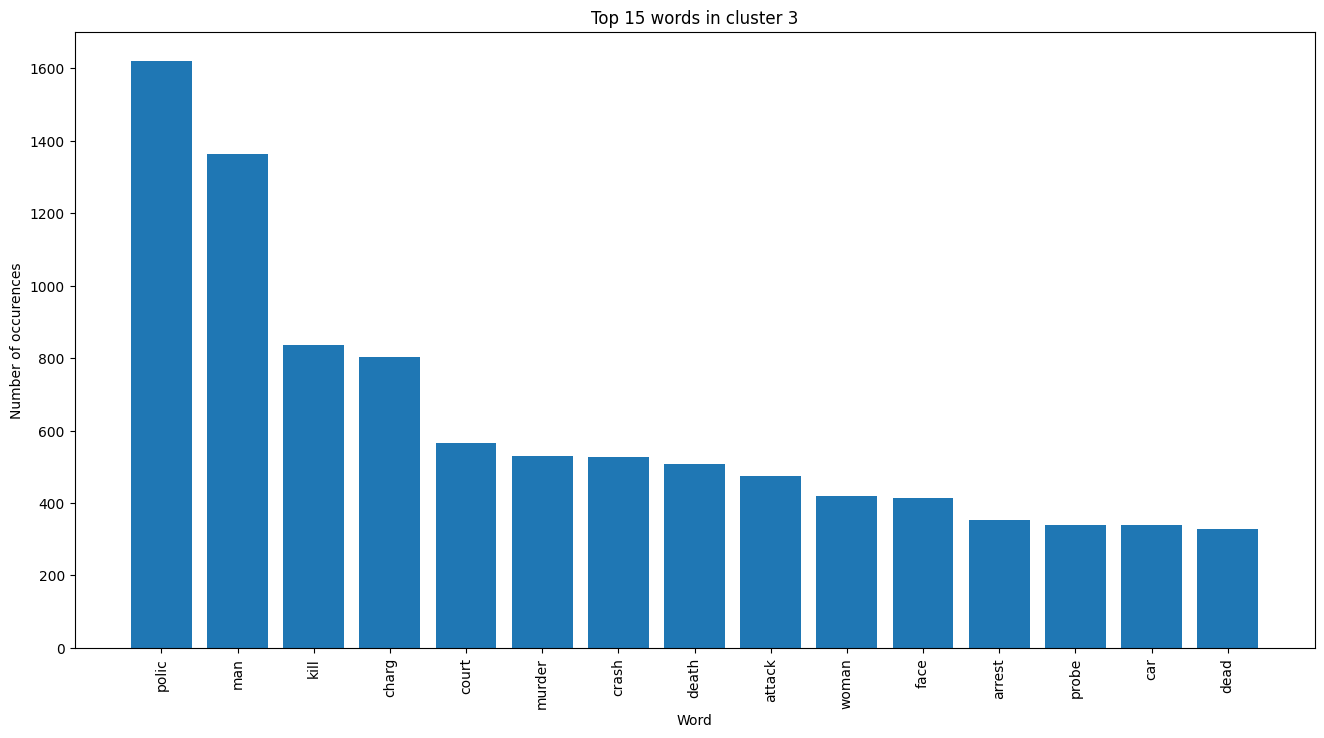

In [44]:
words = []
word_values = []

for i, j in cluster_words[3]:
    words.append(i)
    word_values.append(j)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 15 words in cluster 3');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [45]:
for cluster_index in range(4):
    print("Cluster", cluster_index, ":", [word[0] for word in cluster_words[cluster_index]], end='')
    print("\n")

Cluster 0 : ['plan', 'council', 'new', 'govt', 'fund', 'say', 'boost', 'group', 'water', 'concern', 'health', 'report', 'claim', 'seek', 'warn']

Cluster 1 : ['win', 'world', 'cup', 'final', 'lead', 'set', 'hit', 'face', 'record', 'open', 'year', 'test', 'miss', 'new', 'day']

Cluster 2 : ['govt', 'iraq', 'urg', 'nsw', 'polic', 'continu', 'say', 'australia', 'consid', 'vic', 'qld', 'iraqi', 'forc', 'secur', 'sar']

Cluster 3 : ['polic', 'man', 'kill', 'charg', 'court', 'murder', 'crash', 'death', 'attack', 'woman', 'face', 'arrest', 'probe', 'car', 'dead']



In [46]:
import random

random_index = random.randint(0, len(headlines_full))
random_headline = headlines_full["headline_text"][random_index]
print(random_index, random_headline)

512225 pacquiao to fight clottey in dallas


In [47]:
def predict(cluster_km, headline):
    """
    This function predicts the cluster  of a headline via K-Means
    """
    # Cleaning
    headline_clean = clean_text(headline)
    headline_pre = process_words(headline_clean)  

    # Embeddings
    bag_of_words_list = headline_pre.split()
    number_of_words = len(bag_of_words_list)

    # Process 1st word (to be able to concatenate)
    word_embeddings_array = w2v[bag_of_words_list[0]].reshape(1, embedding_features)

    # To manage headlines with just 1 meaningful word
    word_index = -1
    for word_index, word in enumerate(bag_of_words_list[1:]):
        word_embeddings = w2v[word].reshape(1, embedding_features)
        word_embeddings_array = mx.nd.concat(word_embeddings_array, word_embeddings, dim=0)

    assert(number_of_words == word_index + 2)

    average_embedding_headline_pre = mx.nd.mean(word_embeddings_array, axis=0).reshape(1, embedding_features)

    # Clustering
    selected_cluster = cluster_km.predict(average_embedding_headline_pre.asnumpy())
    
    return selected_cluster    

In [51]:
predicted_cluster = predict(cluster_km, random_headline)
print(predicted_cluster)

[2]
